In [2]:
#マルチコプタシミュレーション Ver 0.1 (暫定版)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

In [3]:
"""
def rk4(func, t, h, x, *p)
4次のルンゲ・クッタ法を一回分計算する関数
    引数リスト
    func:導関数
    t：現在時刻を表す変数
    h：刻み幅
    x：出力変数（求めたい値）
    *p:引数の数が可変する事に対応する、その他の必要変数
※この関数では時刻は更新されないため、これとは別に時間更新をする必要があります。

導関数の書き方
def func(t, x, *state):
    func:自分で好きな関数名をつけられます
    t:時刻変数(変数の文字はtで無くても良い) 
    x:出力変数(変数の文字はxで無くても良い)
    *state:その他の必要変数(引数の数は可変可能))
#関数サンプル
def vdot(t, x, *state):
    s1=state[0]
    s2=state[1]
    return t+x+s1+s2
    
"""

def rk4(func, t, h, x, *p):
    k1=h*func(t, x, *p)
    k2=h*func(t+0.5*h, x+0.5*k1, *p)
    k3=h*func(t+0.5*h, x+0.5*k2, *p) 
    k4=h*func(t+h, x+k3, *p)
    x=x+(k1 + 2*k2 + 2*k3 + k4)/6
    return x


In [4]:
def euler2dcm(euler):
    phi=euler[0]
    theta=euler[1]
    psi=euler[2]
    
    e11= np.cos(theta)*np.cos(psi)
    e12= np.cos(theta)*np.sin(psi)
    e13=-np.sin(theta)
    
    e21= np.sin(phi)*np.sin(theta)*np.cos(psi) - np.cos(phi)*np.sin(psi)
    e22= np.sin(phi)*np.sin(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi)
    e23= np.sin(phi)*np.cos(theta)
    
    e31= np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(phi)*np.sin(psi)
    e32= np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi)
    e33= np.cos(phi)*np.cos(theta)
    
    return((e11,e12,e13),(e21,e22,e23),(e31,e32,e33))

def dcm2euler(e):
    phi=np.arctan2(e[1][2], e[2][2])
    theta=np.arctan2(-e[0][2], np.sqrt(e[1][2]**2 + e[2][2]**2))
    psi=np.arctan2(e[0][1], e[0][0])
    
    return (phi, theta, psi)

def quat2dcm(q):
    q1=q[0]
    q2=q[1]
    q3=q[2]
    q4=q[3]
    
    e11=   q1**2 - q2**2 - q3**2 + q4**2
    e12= 2 * (q1*q2 + q3*q4)
    e13= 2 * (q1*q3 - q2*q4)
    
    e21= 2 * (q1*q2 - q3*q4)
    e22= - q1**2 + q2**2 - q3**2 + q4**2
    e23= 2 * (q2*q3 + q1*q4)
    
    e31= 2 * (q1*q3 + q2*q4)
    e32= 2 * (q2*q3 - q1*q4)
    e33= - q1**2 - q2**2 + q3**2 + q4**2
    
    return((e11,e12,e13),(e21,e22,e23),(e31,e32,e33))

def dcm2quat(e):
    e11=e[0][0]
    e12=e[0][1]
    e13=e[0][2]
    e21=e[1][0]
    e22=e[1][1]
    e23=e[1][2]
    e31=e[2][0]
    e32=e[2][1]
    e33=e[2][2]
    
    q1=0.5*np.sqrt(1 + e11 - e22 - e33)
    q2=0.5*np.sqrt(1 - e11 + e22 - e33)
    q3=0.5*np.sqrt(1 - e11 - e22 + e33)
    q4=0.5*np.sqrt(1 + e11 + e22 + e33)
    
    q=[q1, q2, q3, q4]
    idx=q.index(max(q))
    
    if idx==0:
        q[1]=( e12+e21)/4/q1
        q[2]=( e13+e31)/4/q1
        q[3]=( e23-e32)/4/q1
    elif idx==1:
        q[0]=( e12+e21)/4/q2
        q[2]=( e23+e32)/4/q2
        q[3]=(-e13+e31)/4/q2
    elif idx==2:
        q[0]=( e13+e31)/4/q3
        q[1]=( e23+e32)/4/q3
        q[3]=( e12-e21)/4/q3
    elif idx==3:
        q[0]=( e23-e32)/4/q4
        q[1]=(-e13+e31)/4/q4
        q[2]=( e12+e21)/4/q4

    return q

In [131]:
def plotdata(T,tmin,tmax,out,angle,u_input):

    scaleflag=True
    
    PHI=angle[0]
    THETA=angle[1]
    PSI=angle[2]
    U1=u_input[0]
    U2=u_input[1]
    U3=u_input[2]
    U4=u_input[3]
    
    fig=plt.figure(figsize=(32,21))
    ax1=fig.add_subplot(7,4,1)
    ax2=fig.add_subplot(7,4,2)
    ax3=fig.add_subplot(7,4,3)

    ax4=fig.add_subplot(7,4,5)
    ax5=fig.add_subplot(7,4,6)
    ax6=fig.add_subplot(7,4,7)

    ax7=fig.add_subplot(7,4,9)
    ax8=fig.add_subplot(7,4,10)
    ax9=fig.add_subplot(7,4,11)

    ax10=fig.add_subplot(7,4,13)
    ax11=fig.add_subplot(7,4,14)
    ax12=fig.add_subplot(7,4,15)

    ax13=fig.add_subplot(7,4,17)
    ax14=fig.add_subplot(7,4,18)
    ax15=fig.add_subplot(7,4,19)
    ax16=fig.add_subplot(7,4,20)

    ax17=fig.add_subplot(7,4,21)
    ax18=fig.add_subplot(7,4,22)
    ax19=fig.add_subplot(7,4,23)
    ax20=fig.add_subplot(7,4,24)

    ax21=fig.add_subplot(7,4,25)
    ax22=fig.add_subplot(7,4,26)
    ax23=fig.add_subplot(7,4,27)
    ax24=fig.add_subplot(7,4,28)

    #uvw
    if scaleflag==True:
        out[0]=np.round(np.array(out[0]),8)
        out[1]=np.round(np.array(out[1]),8)
        out[2]=np.round(np.array(out[2]),8)
    
    ax1.plot(T, out[0],lw=2, label='u')
    ax1.grid()
    #ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('u[m/s]',fontsize=20)
    ax1.set_xlim(tmin,tmax)
    
    ax2.plot(T, out[1],lw=2, label='v')
    ax2.grid()
    #ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('v[m/s]',fontsize=20)
    ax2.set_xlim(tmin,tmax)

    ax3.plot(T, out[2],lw=2, label='w')
    ax3.grid()
    #ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('w[m/s]',fontsize=20)
    ax3.set_xlim(tmin,tmax)

    #pqr
    if scaleflag==True:
        out[3]=np.round(np.array(out[3]),8)
        out[4]=np.round(np.array(out[4]),8)
        out[5]=np.round(np.array(out[5]),8)
    
    ax4.plot(T, out[3],lw=2, label='p')
    ax4.grid()
    #ax4.set_xlabel('Time(s)')
    ax4.set_ylabel('p[rad/s]',fontsize=20)
    ax4.set_xlim(tmin,tmax)

    ax5.plot(T, out[4],lw=2, label='q')
    ax5.grid()
    #ax5.set_xlabel('Time(s)')
    ax5.set_ylabel('q[rad/s]',fontsize=20)
    ax5.set_xlim(tmin,tmax)

    ax6.plot(T, out[5],lw=2, label='r')
    ax6.grid()
    #ax6.set_xlabel('Time(s)')
    ax6.set_ylabel('r[rad/s]',fontsize=20)
    ax6.set_xlim(tmin,tmax)

    #xeyeze
    if scaleflag==True:
        out[14]=np.round(np.array(out[14]),8)
        out[15]=np.round(np.array(out[15]),8)
        out[16]=np.round(np.array(out[16]),8)
    
    ax7.plot(T, out[14],lw=2, label='xe')
    ax7.grid()
    #ax7.set_xlabel('Time(s)')
    ax7.set_ylabel('xe[m]',fontsize=20)
    ax7.set_xlim(tmin,tmax)

    ax8.plot(T, out[15],lw=2, label='ye')
    ax8.grid()
    #ax8.set_xlabel('Time(s)')
    ax8.set_ylabel('ye[m]',fontsize=20)
    ax8.set_xlim(tmin,tmax)

    ax9.plot(T, out[16],lw=2, label='ze')
    ax9.grid()
    #ax9.set_xlabel('Time(s)')
    ax9.set_ylabel('ze[m]',fontsize=20)
    ax9.set_xlim(tmin,tmax)

    #phi theta psi
    PHI=np.array(PHI)*180/np.pi
    THETA=np.array(THETA)*180/np.pi
    PSI=np.array(PSI)*180/np.pi
    
    if scaleflag==True:
        PHI=np.round(PHI,8)
        THETA=np.round(THETA,8)
        PSI=np.round(PSI,8)

    ax10.plot(T, PHI, lw=2, label='$\phi$')
    ax10.grid()
    #ax10.set_xlabel('Time(s)')
    ax10.set_ylabel('$\phi$[rad]',fontsize=20)
    ax10.set_xlim(tmin,tmax)

    ax11.plot(T, THETA, lw=2, label='$\Theta$')
    ax11.grid()
    #ax11.set_xlabel('Time(s)')
    ax11.set_ylabel('$\\theta$[deg]',fontsize=20)
    ax11.set_xlim(tmin,tmax)

    ax12.plot(T, PSI, lw=2, label='$\psi$')
    ax12.grid()
    #ax12.set_xlabel('Time(s)')
    ax12.set_ylabel('$\psi$[deg]',fontsize=20)
    ax12.set_xlim(tmin,tmax)

    #quatanion
    if scaleflag==True:
        out[10]=np.round(np.array(out[10]),8)
        out[11]=np.round(np.array(out[11]),8)
        out[12]=np.round(np.array(out[12]),8)
        out[13]=np.round(np.array(out[13]),8)
    
    ax13.plot(T, out[10],lw=2, label='q1')
    ax13.grid()
    #ax13.set_xlabel('Time(s)')
    ax13.set_ylabel('q1',fontsize=20)
    ax13.set_xlim(tmin,tmax)

    ax14.plot(T, out[11],lw=2, label='q2')
    ax14.grid()
    #ax14.set_xlabel('Time(s)')
    ax14.set_ylabel('q2',fontsize=20)
    ax14.set_xlim(tmin,tmax)

    ax15.plot(T, out[12],lw=2, label='q3')
    ax15.grid()
    #ax15.set_xlabel('Time(s)')
    ax15.set_ylabel('q4',fontsize=20)
    ax15.set_xlim(tmin,tmax)

    ax16.plot(T, out[13],lw=2, label='q4')
    ax16.grid()
    #ax16.set_xlabel('Time(s)')
    ax16.set_ylabel('q4',fontsize=20)
    ax16.set_xlim(tmin,tmax)

    #motor omega
    if scaleflag==True:
        out[6]=np.round(np.array(out[6]),8)
        out[7]=np.round(np.array(out[7]),8)
        out[8]=np.round(np.array(out[8]),8)
        out[9]=np.round(np.array(out[9]),8)
    
    ax17.plot(T, out[6],lw=2, label='$\omega_fr$')
    ax17.grid()
    #ax17.set_xlabel('Time(s)')
    ax17.set_ylabel('$\omega_{fr}$[rad/s]',fontsize=20)
    ax17.set_xlim(tmin,tmax)

    ax18.plot(T, out[7],lw=2, label='$\omega_fl$')
    ax18.grid()
    #ax18.set_xlabel('Time(s)')
    ax18.set_ylabel('$\omega_{fl}$[rad/s]',fontsize=20)
    ax18.set_xlim(tmin,tmax)

    ax19.plot(T, out[8],lw=2, label='$\omega_rr')
    ax19.grid()
    #ax19.set_xlabel('Time(s)')
    ax19.set_ylabel('$\omega_{rr}$[rad/s]',fontsize=20)
    ax19.set_xlim(tmin,tmax)

    ax20.plot(T, out[9],lw=2, label='$\omega_rl$')
    ax20.grid()
    #ax20.set_xlabel('Time(s)')
    ax20.set_ylabel('$\omega_{rl}$[rad/s]',fontsize=20)
    ax20.set_xlim(tmin,tmax)

    #input
    if scaleflag==True:
        U1=np.round(np.array(U1),8)
        U2=np.round(np.array(U2),8)
        U3=np.round(np.array(U3),8)
        U4=np.round(np.array(U4),8)

    ax21.plot(T, U1,lw=2, label='u1')
    ax21.grid()
    ax21.set_xlabel('Time(s)')
    ax21.set_ylabel('u1[V]',fontsize=20)
    ax21.set_xlim(tmin,tmax)

    ax22.plot(T, U2,lw=2, label='u2')
    ax22.grid()
    ax22.set_xlabel('Time(s)')
    ax22.set_ylabel('u2[V]',fontsize=20)
    ax22.set_xlim(tmin,tmax)

    ax23.plot(T, U3,lw=2, label='u3')
    ax23.grid()
    ax23.set_xlabel('Time(s)')
    ax23.set_ylabel('u3[V]',fontsize=20)
    ax23.set_xlim(tmin,tmax)

    ax24.plot(T, U4,lw=2, label='u4')
    ax24.grid()
    ax24.set_xlabel('Time(s)')
    ax24.set_ylabel('u4[V]',fontsize=20)
    ax24.set_xlim(tmin,tmax)

    ax21.set_ylim(-1.0,11.5)
    ax22.set_ylim(-1.0,11.5)
    ax23.set_ylim(-1.0,11.5)
    ax24.set_ylim(-1.0,11.5)

    
    
    plt.show()


In [148]:
#マルチコプタの運動クラス
class multicopter:
    
    grav=9.80665
    
    def __init__(self,\
                 M=7.1e-1,\
                 Jmot=3.4e-6,\
                 D=0.0,\
                 Qf=0.0,\
                 R=0.12,\
                 K=3.28e-3,\
                 Ct=8.3e-7,\
                 Cq=3.0e-8,\
                 Ix=3.24e-3,\
                 Iy=3.68e-3,\
                 Iz=6.26e-3,\
                 l=0.18):
        
        ###モータのパラメータ
        self.M=M
        self.J=Jmot
        self.D=D
        self.Qf=Qf
        self.R=R
        self.K=K
        self.Ct=Ct
        self.Cq=Cq
        self.Ix=Ix
        self.Iy=Iy
        self.Iz=Iz
        self.l=l
        
    #導関数
    def xdot(self, t, x, *uin):
        #print(uin[0])
        u=x[0]
        v=x[1]
        w=x[2]
        p=x[3]
        q=x[4]
        r=x[5]
        omega_fr=x[6]
        omega_fl=x[7]
        omega_rr=x[8]
        omega_rl=x[9]
        q1=x[10]
        q2=x[11]
        q3=x[12]
        q4=x[13]
        xe=x[14]
        ye=x[15]
        ze=x[16]
                
        efr=uin[0][0]
        efl=uin[0][1]
        err=uin[0][2]
        erl=uin[0][3]
        
        DCM=quat2dcm((q1,q2,q3,q4))
        phi, theta, psi=dcm2euler(DCM)
                
        Tfr=self.Ct*omega_fr**2
        Tfl=self.Ct*omega_fl**2
        Trr=self.Ct*omega_rr**2
        Trl=self.Ct*omega_rl**2        
        
        Qfr=self.Cq*omega_fr**2
        Qfl=self.Cq*omega_fl**2
        Qrr=self.Cq*omega_rr**2
        Qrl=self.Cq*omega_rl**2
        
        udot=-self.grav*np.sin(theta) -q*w +r*v
        vdot= self.grav*np.cos(theta)*np.sin(phi) -r*u +p*w
        wdot= self.grav*np.cos(theta)*np.cos(phi) -p*v +p*u +\
                -(Tfr + Tfl + Trr + Trl)/self.M
        
        pdot=(0.5*self.l*(Tfr + Trr - Tfl - Trl) - (self.Iz -self.Iy)*q*r)/self.Ix
        qdot=(0.5*self.l*(Trr + Trl - Tfr - Tfl) - (self.Ix -self.Iz)*r*p)/self.Iy
        rdot=((Qfr + Qrl - Qfl - Qrr) - (self.Iy -self.Ix)*p*q)/self.Iz
        
        omegadot_fr=(self.K/self.R*efr \
                    - (self.D + self.K**2/self.R)*omega_fr\
                    - self.Cq*omega_fr**2\
                    )/self.J
        omegadot_fl=(self.K/self.R*efl \
                    - (self.D + self.K**2/self.R)*omega_fl\
                    - self.Cq*omega_fl**2\
                    )/self.J
        omegadot_rr=(self.K/self.R*err \
                    - (self.D + self.K**2/self.R)*omega_rr\
                    - self.Cq*omega_rr**2\
                    )/self.J
        omegadot_rl=(self.K/self.R*erl \
                    - (self.D + self.K**2/self.R)*omega_rl\
                    - self.Cq*omega_rl**2\
                    )/self.J
        
        q1dot=0.5*( r*q2 -q*q3 +p*q4)
        q2dot=0.5*(-r*q1 +p*q3 +q*q4)
        q3dot=0.5*( q*q1 -p*q2 +r*q4)
        q4dot=0.5*(-p*q1 -q*q2 -r*q3)
        
        xedot=DCM[0][0]*u + DCM[1][0]*v + DCM[2][0]*w
        yedot=DCM[0][1]*u + DCM[1][1]*v + DCM[2][1]*w
        zedot=DCM[0][2]*u + DCM[1][2]*v + DCM[2][2]*w
        
        return np.array([udot, vdot, wdot,\
                    pdot, qdot, rdot,\
                    omegadot_fr, omegadot_fl, omegadot_rr, omegadot_rl,\
                    q1dot, q2dot, q3dot, q4dot,\
                    xedot, yedot, zedot])
    

class pid:
    def __init__(self, kp, ti, td,limit_upper=100.0,limit_lower=-100.0,limitter=False):
        self.Sum=0.0
        self.olderr=0.0
        self.oldtime=0.0
        self.limit_upper= limit_upper
        self.limit_lower= limit_lower
        self.limitterFlag=True
        self.Kp=kp
        self.Ti=ti
        self.Td=td
        self.u=0.0
    
    def controller(self, y, ref, t):
        err=ref-y
        period=t-self.oldtime
        self.Sum=self.Sum+err*period
        errdot=(err-self.olderr)/period
        
        self.u=self.Kp*(err + self.Sum/self.Ti + self.Td*errdot)
        #print(self.u,self.Sum,errdot,err,self.olderr,period)
        #print(self.Kp, self.Ti, self.Td)
        #リミッター
        if self.limitterFlag==True:
            if self.u>self.limit_upper:
                self.u=self.limit_upper
            elif self.u<self.limit_lower:
                self.u=self.limit_lower
        
        self.oldtime=t
        self.olderr=err
    
        return self.u

class vpid:
    def __init__(self, kp, ti, td,limit_upper=100.0,limit_lower=-100.0,limitter=False):
        self.Sum=0.0
        self.olderr1=0.0
        self.olderr2=0.0
        self.oldtime=0.0
        self.limit_upper= limit_upper
        self.limit_lower= limit_lower
        self.limitterFlag=True
        self.Kp=kp
        self.Ti=ti
        self.Td=td
        self.u=0.0
    
    def controller(self, y, ref, t):
        err=ref-y
        period=t-self.oldtime
        self.Sum=self.Sum+err*period
        #errdot=(err-self.olderr)/period
        
        self.u=self.u\
            + self.Kp*(err-self.olderr1 + period*err/self.Ti + self.Td*(err-2*self.olderr1+self.olderr2)/period)
        #print(self.u,self.Sum,errdot,err,self.olderr,period)
        #print(self.Kp, self.Ti, self.Td)
        #リミッター
        if self.limitterFlag==True:
            if self.u>self.limit_upper:
                self.u=self.limit_upper
            elif self.u<self.limit_lower:
                self.u=self.limit_lower
        
        self.oldtime=t
        
        self.olderr2=self.olderr1
        self.olderr1=err
    
        return self.u

  0%|          | 0/50000 [00:00<?, ?it/s]

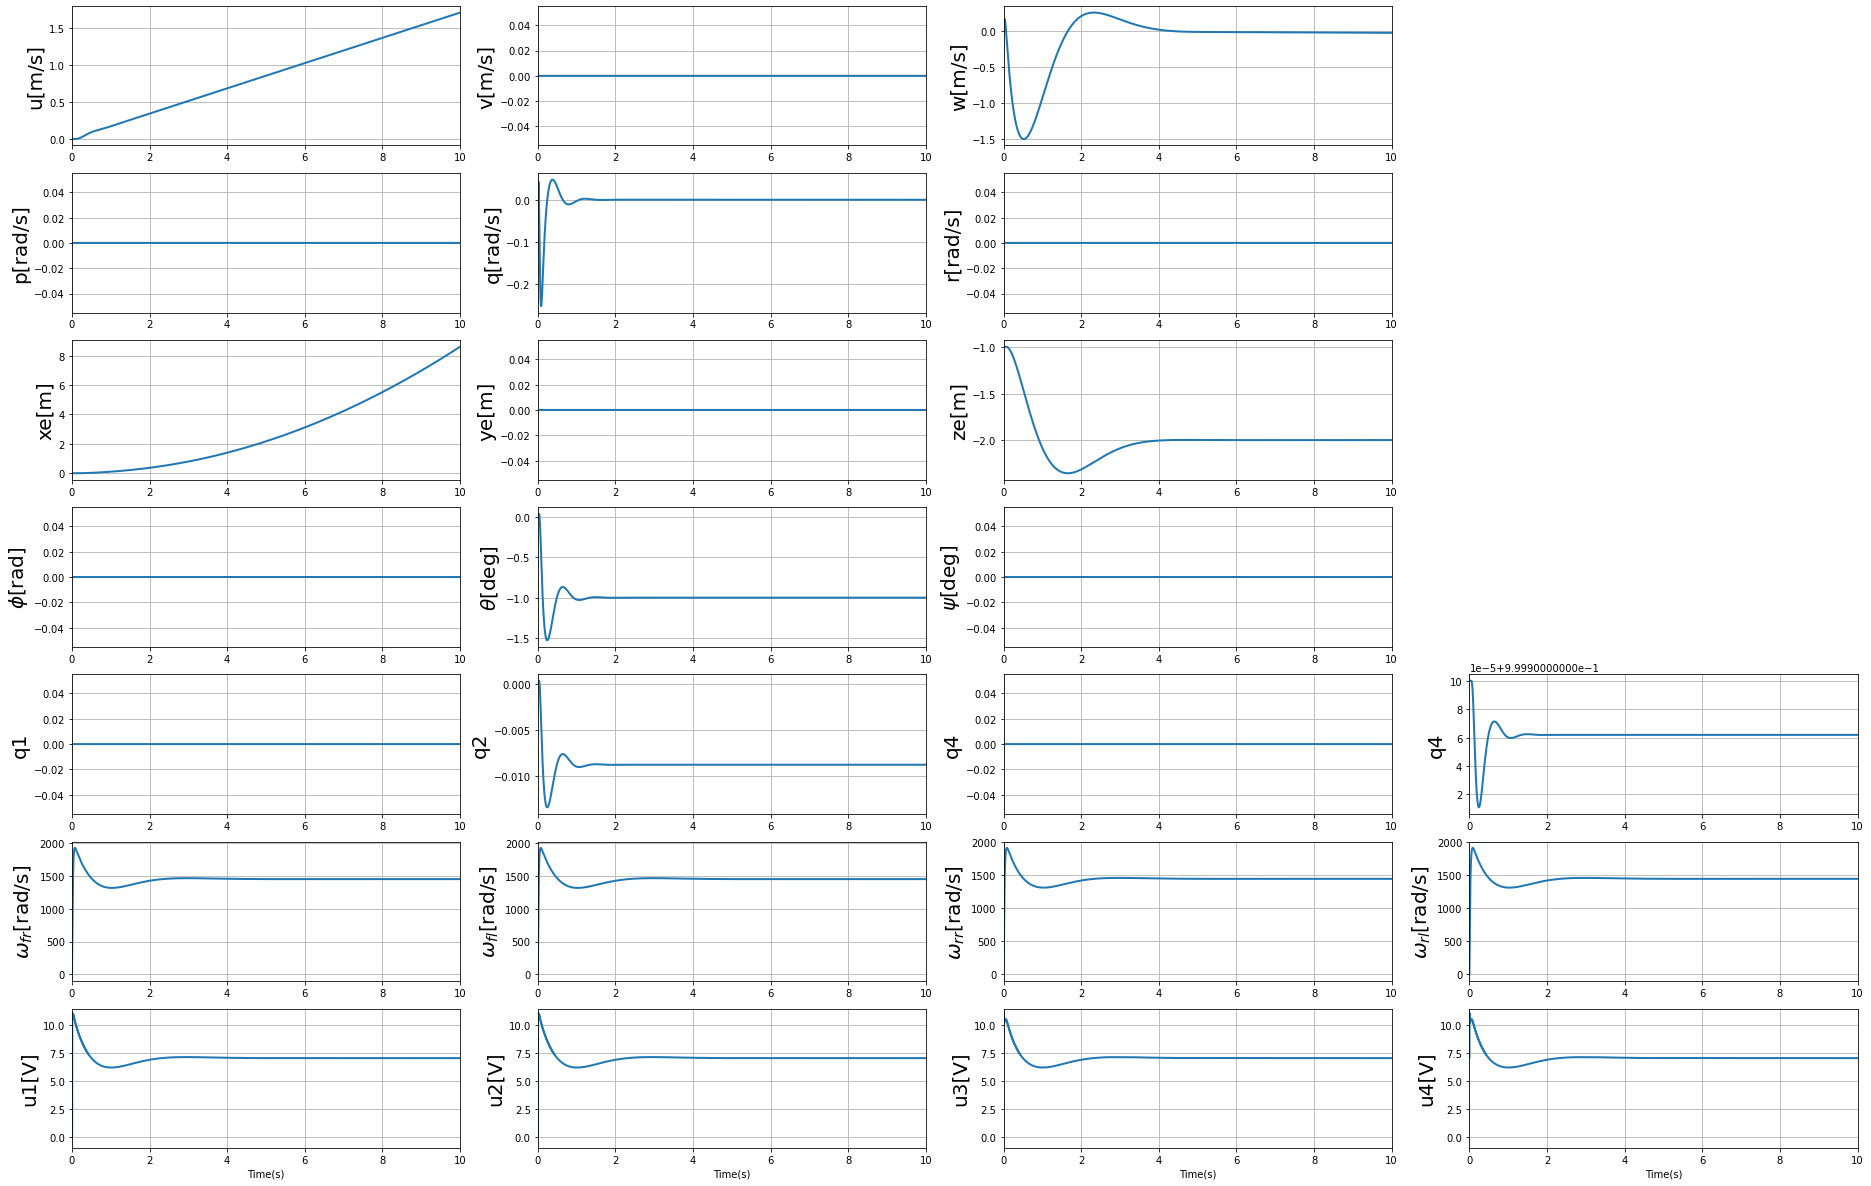

In [152]:
#ここからメイン
copter=multicopter()

#刻み幅
fc=1/500
h=fc/10
if h>1e-3:
    h=1e-3

#各状態初期化
t=0.0
dcm=euler2dcm((0.0,0.0,0.0))
q1,q2,q3,q4=dcm2quat(dcm)
u=v=w=0.0
p=q=r=0.0
omega_fr=omega_fl=omega_rr=omega_rl=0.0
xe=ye
ze=-1.0
x=np.array([u,v,w,\
            p,q,r,\
            omega_fr,omega_fl,omega_rr,omega_rl,
            q1,q2,q3,q4,
            xe,ye,ze])

#ホバリング状態の入力
e0=(copter.D*copter.R+copter.K**2)/2/copter.K*np.sqrt(copter.grav*copter.M/copter.Ct)\
    + copter.Cq*copter.R*copter.M*copter.grav/4/copter.K/copter.Ct\
    + copter.R*copter.Qf/copter.K

#入力の初期値
u1=e0
u2=e0
u3=e0
u4=e0

#シミュレーション時間
fintime=10.0

#制御開始時間
start_control_time=0.0
next_control_time=start_control_time
oldtime=start_control_time

T=[]
X=[]
out=[[],[],[],[],[],\
   [],[],[],[],[],\
   [],[],[],[],[],\
   [],[],[],[],[],\
   []]

#角速度制御PID
#roll
Kp_p=  3.3656
Ti_p=  0.1000
Td_p=  0.0112
pid_p=pid(Kp_p, Ti_p, Td_p)
#pitch
Kp_q= 3.8042
Ti_q= 0.1
Td_q= 0.0111
pid_q=pid(Kp_q, Ti_q, Td_q)
#yaw
Kp_r=  9.4341
Ti_r=  0.1100
Td_r=  0.0056
pid_r=pid(Kp_r, Ti_r, Td_r)

#角度制御
#roll angle
Kp_phi= 25.9369
Ti_phi=  0.0700
Td_phi=  0.0352
pid_phi=pid(Kp_phi, Ti_phi, Td_phi)
#pitch angle
Kp_theta= 8.5583
Ti_theta= 0.1000
Td_theta= 0.0522
pid_theta=pid(Kp_theta, Ti_theta, Td_theta)
#yaw angle
Kp_psi=  9.0256
Ti_psi=  0.1100
Td_psi=  0.0034
pid_psi=pid(Kp_psi, Ti_psi, Td_psi)

#高度制御PID
Kp_alt=-13.2257
Ti_alt=  1.5000
Td_alt=  0.5638
#Kp_alt= -7.7266
#Ti_alt=  2.0000
#Td_alt=  0.7187
#Kp_alt=-19.8678
#Ti_alt=  2.0000
#Td_alt=  0.4591
pid_alt=pid(Kp_alt, Ti_alt, Td_alt, limitter=False)

theta=0.0
flag=False

U1=[]
U2=[]
U3=[]
U4=[]

for _ in tqdm( range(int(fintime/h)) ):
    #記録
    T.append(t)
    X.append(x)
    U1.append(u1)
    U2.append(u2)
    U3.append(u3)
    U4.append(u4)
    
    #クォータニオンからオイラー角取得
    q1=x[10]
    q2=x[11]
    q3=x[12]
    q4=x[13]
    DCM=quat2dcm((q1,q2,q3,q4))
    phi, theta, psi=dcm2euler(DCM)
 
    #制御
    if t>start_control_time:
        if flag==False:
            flag=True
            
            #外乱生成
            #DCM=euler2dcm((0,1.0*np.pi/180,0))
            #q1,q2,q3,q4=dcm2quat(DCM)
            #x[10]=q1
            #x[11]=q2
            #x[12]=q3
            #x[13]=q4
            
            #角度目標値
            rx= 0.0*np.pi/180
            ry= -1.0*np.pi/180
            rz= 0.0*np.pi/180
        
        if t>next_control_time:
            deltat=t-oldtime

            #roll/ピッチ角/ヨー角 制御
            ux=pid_phi.controller(phi, rx, t)
            uy=pid_theta.controller(theta, ry, t)
            uz=pid_psi.controller(psi, rz, t)
 
            #ロール・ピッチ角速度 制御
            up=pid_p.controller(x[3], ux, t)
            uq=pid_q.controller(x[4], uy, t)
            ur=pid_r.controller(x[5], uz, t)

            #高度制御
            ualt=pid_alt.controller(x[16], -2.0, t)

            #Mixing
            u1=e0 + (ualt +up -uq +ur)/4
            u2=e0 + (ualt -up -uq -ur)/4
            u3=e0 + (ualt +up +uq -ur)/4
            u4=e0 + (ualt -up +uq +ur)/4

            #制御入力リミッター
            if True:#True:リミッタON False:リミッタOFF
                if u1>11.1:
                    u1=11.1
                if u1<0:
                    u1=0
                if u2>11.1:
                    u2=11.1
                if u2<0:
                    u2=0
                if u3>11.1:
                    u3=11.1
                if u3<0:
                    u3=0
                if u4>11.1:
                    u4=11.1
                if u4<0:
                    u4=0

            oldtime=t
            next_control_time = next_control_time + fc
    
    U=np.array([u1,u2,u3,u4])
    x=rk4(copter.xdot, t, h, x, U)
    t=t+h

T.append(t)
X.append(x)
U1.append(u1)
U2.append(u2)
U3.append(u3)
U4.append(u4)

for x in X:
    for i in range(len(x)):
        out[i].append(x[i])

PHI=[]
THETA=[]
PSI=[]
for q1,q2,q3,q4 in zip(out[10],out[11],out[12],out[13]):
    DCM=quat2dcm((q1,q2,q3,q4))
    phi, theta, psi=dcm2euler(DCM)
    PHI.append(phi)
    THETA.append(theta)
    PSI.append(psi)
    
T=np.array(T)
angle=[PHI,THETA,PSI]
u=[U1,U2,U3,U4]

tmin=min(T)
tmax=max(T)
plotdata(T,tmin,fintime,out,angle,u)
#plotdata(T,tmin,1,out,angle,u)



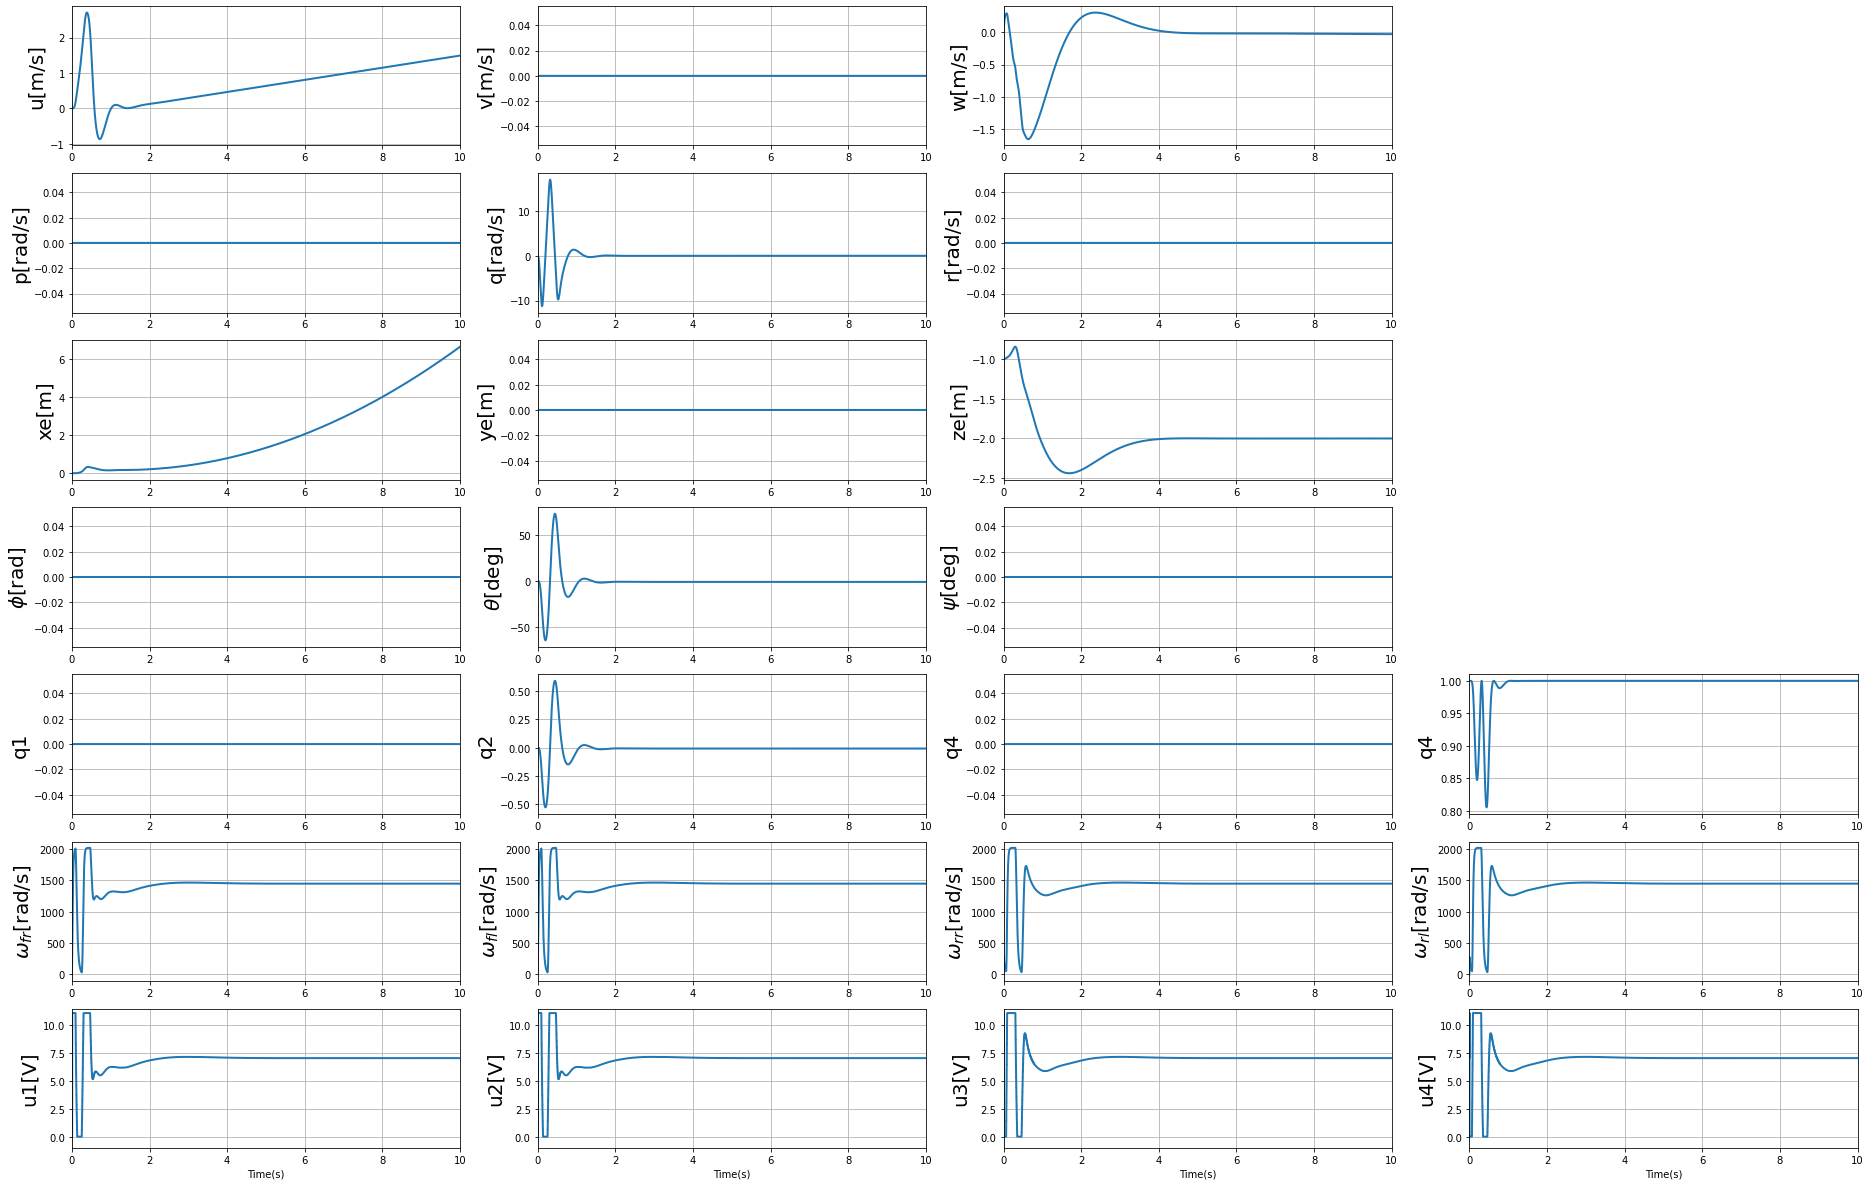

In [151]:
plotdata(T,tmin,fintime,out,angle,u)